<a href="https://colab.research.google.com/github/vgorbikov/mldlvsu_labs/blob/main/Lab_3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений с применением свёрточных нейронных сетей

**Цель работы** — изучение основ свёрточных нейронных сетей,
понимание их ключевых принципов и приобретение навыков практического
применения. В рамках задания рассматривается архитектура свёрточных
сетей, основные типы слоёв и операции, используемые для обработки
изображений. Практическая часть включает реализацию модели для решения
задачи классификации изображений, что способствует закреплению
теоретических знаний и развитие практических умений.

## Задание

**Разработайте и обучите собственную архитектуру свёрточной
нейронной сети для решения вашей задачи классификации изображений.**
1. Обучите базовую модель CNN из демонстрационного примера и
проведите серию экспериментов по оптимизации гиперпараметров для
повышения её точности. Сравните результаты тестирования исходной
модели с улучшенной версией. Разрешается реализовать с нуля любую
известную архитектуру (например, VGG, ResNet и т.д.).
2. Сравните вашу модель с двумя любыми предварительно обученными
нейросетями (например, VGG16, ResNet50 и др.).

Для достижения наиболее высокой точности на тестовых данных, *вы
можете оптимизировать следующие параметры*:
- Архитектура модели:
  - количество блоков свёртки;
  - количество фильтров (filters/out_channels) и размер ядра
(kernel_size) в свёрточных слоях;
  - виды нелинейных функций активации;
  - виды слоёв пулинга:
    - Average Pooling;
    - Max Pooling;
    - Conv2D с параметром stride=2.
  - архитектура классификационного слоя:
    - вариант с «Flatten + промежуточным полносвязным слоем»;
    - вариант с «Global Average Pooling».
- Методы борьбы с переобучением:
  - Dropout: отключает случайные нейроны. Этот слой часто
применяется после свёрточных слоев с активацией или перед
последним классификационным слоем;
  - Dropout2D: отключает целые каналы (фильтры) в свёрточных
слоях. Этот слой обычно применяется после свёрточных слоев с
активацией;
  - BatchNormalization: нормализует активации слоев, улучшает
стабильность и ускоряет обучение. Обычно располагается между
свёрточным слоем и функцией активации.
- Оптимизация процесса обучения:
  - оптимизатор и скорость обучения;
  - размер мини-пакета;
  - попробуйте использовать расписание скорости обучения Learning
Rate Schedule, например ReduceLROnPlateau;
  - при дисбалансе классов попробуйте заменить классическую Cross
Entropy Loss на Focal Loss.
- Дополнительные техники:
  - попробуйте применить технику искусственного увеличения
данных (Data Augmentation).

### Вариант 11

Классификация пород кошек (11 различных пород):
https://www.kaggle.com/datasets/ramzanlafir/cat-breed-classification-11-classes/data

### Демонстрационный пример

[Ссылка](https://colab.research.google.com/drive/1d-cH1MGdQCE__5twwlEwLkPKMZ_nkn9V?usp=sharing)

## Решение

In [1]:
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 37.6 MB/s eta 0:00:00


In [2]:
import os

import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torchsummary import summary
import torch.nn.init as init

### Подготовка данных

In [3]:
# Скачиваем датасет (корневая папка датасета называется Cat_Breed)
path = kagglehub.dataset_download("ramzanlafir/cat-breed-classification-11-classes") + '/Cat_Breed'

categories = os.listdir(path)
categories_oh = [[0]*len(categories) for i in range(len(categories))]
for i in range(len(categories)):
  categories_oh[i][i] = 1

classes_count = len(categories)

100%|██████████| 717M/717M [00:20<00:00, 37.1MB/s]

Extracting files...


In [4]:
val_percent = 0.1 # доля примеров, идущая на валидационную выборку
test_percent = 0.1 # доля примеров, идущая на тестовую выборку

# получили три массива с сопоставлением [путь к файлу : класс]
train_metadata = []
val_metadata = []
test_metadata = []

for dir_name in os.listdir(path):
  cat_label = categories_oh[categories.index(dir_name)]
  full_path = path+'/'+dir_name
  examples_p = os.listdir(full_path)
  examples_count = len(examples_p)

  test_count = round(examples_count*test_percent)
  val_count = round(examples_count*val_percent)
  train_count = examples_count - (test_count + val_count)

  train_metadata += [[full_path+'/'+ex, cat_label] for ex in examples_p[:train_count]]
  val_metadata += [[full_path+'/'+ex, cat_label] for ex in examples_p[train_count:train_count+val_count]]
  test_metadata += [[full_path+'/'+ex, cat_label] for ex in examples_p[train_count+val_count:]]



In [5]:
print(f'Train size: {len(train_metadata)}')
print(f'Val size:   {len(val_metadata)}')
print(f'Test size:  {len(test_metadata)}')

Train size: 4399
Val size:   550
Test size:  550


In [6]:
# трансформации для исходных изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# class ImageDS_HDDBased(Dataset):
#   '''
#   Датасет с изображениями - подгружает изображения с диска "на лету", применяя необходимые преобразования формата
#   '''
#   def __init__(self, metadata: list, transform) -> None:
#     super().__init__()
#     self.X = [s[0] for s in metadata]
#     self.Y = [s[1] for s in metadata]
#     self.transform = transform

#   def __len__(self):
#     return len(self.Y)

#   def __getitem__(self, index):
#     x = Image.open(self.X[index])
#     if x.mode != 'RGB': # !ВАЖНО - в датасете есть картинки, открывающиеся в моноканальном режиме
#       x = x.convert('RGB')
#     x = self.transform(x)
#     y = torch.tensor(self.Y[index], dtype=torch.float)
#     return x, y


In [7]:
class ImageDS(Dataset):
  '''
  Датасет с изображениями - подгружает изображения с диска "на лету", применяя необходимые преобразования формата
  '''
  def __init__(self, metadata: list, transform) -> None:
    super().__init__()
    self.transform = transform
    self.X = [self.transform(self.__open_img(s[0])) for s in metadata]
    self.Y = [torch.tensor(s[1], dtype=torch.float) for s in metadata]

  def __open_img(self, img_path: str):
    im = Image.open(img_path)
    if im.mode != 'RGB': # !ВАЖНО - в датасете есть картинки, открывающиеся в моноканальном режиме
      im = im.convert('RGB')
    return im

  def __len__(self):
    return len(self.Y)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [8]:
# датасеты с изображениями для обучающей/валидационной/тестовой выборки
train_dataset = ImageDS(train_metadata, transform)
val_dataset = ImageDS(val_metadata, transform)
test_dataset = ImageDS(test_metadata, transform)

Exotic Shorthair


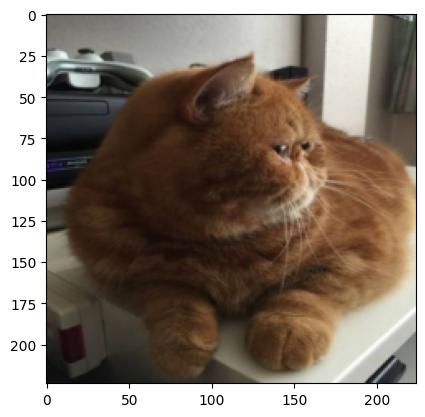

In [9]:
# посмотрим на случайный пример из тренировочной выборки
rand_ex_no = np.random.randint(0, len(train_dataset))

ex = (train_dataset[rand_ex_no][0]).swapaxes(0, 2).swapaxes(0, 1) #для корректного отображения с помощью pyplot нужно свапнуть оси
print(categories[train_dataset[rand_ex_no][1].argmax()])

plt.imshow(ex)
plt.show()

In [10]:
# Создание загрузчика данных для обучающей выборки
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)

# Создание загрузчика данных для валидационной выборки
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=True)

# Создание загрузчика данных для тестовой выборки
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=True)

### Описание моделей

#### Из демонстрационного примера

In [11]:
def create_pretrained_resnet50(num_classes):
    '''
    Загрузка предварительно обученной модели. Взято из демонстрационного примера
    '''
    # Загружаем предобученную модель ResNet50, которая обучена на наборе данных ImageNet (1000 классов различных объектов, более 1 млн. изображений).
    resnet50 = models.resnet50(pretrained=True)
    # Получаем количество входных нейронов для последнего полносвязного слоя (fc)
    fc_inputs = resnet50.fc.in_features
    # Заменяем стандартный последний слой модели на новый, подходящий для нашей задачи (поскольку там выходной слой с 1000 нейронами)
    # Новый слой: линейный слой, который принимает fc_inputs и выдаёт num_classes
    # После линейного слоя добавляем функцию активации Softmax, чтобы получить вероятности классов
    resnet50.fc = nn.Sequential(nn.Linear(fc_inputs, num_classes),
                                nn.Softmax(dim=1))
    return resnet50

In [12]:
class ConvNetBase(nn.Module):
    '''
    Базовый пример свёрточной сети из демонстрационного примера
    '''
    def __init__(self, num_classes):
        super(ConvNetBase, self).__init__()

        # 1 блок свёртки (Conv + ReLU + MaxPool)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2 блок свёртки (Conv + ReLU + MaxPool)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3 блок свёртки (Conv + ReLU + MaxPool)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4 блок свёртки (Conv + ReLU + MaxPool)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling (глобальное усреднение по карте признаков)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Полносвязный слой для классификации, 256 входных нейронов (соответствует количеству фильтров)
        # Выходных нейронов столько, сколько классов в задаче (num_classes)
        self.fc = nn.Linear(256, num_classes)

        # Функция активации Softmax для нормализации выходных значений в вероятности, сумма которых равна 1
        # Softmax применяется при многоклассовой классификации для выбора вероятности каждого класса
        # Мы не будем её здесь использовать, поскольку CrossEntropy лучше работает с логитами
        #self.softmax = nn.Softmax(dim=1) # указываем размерность, по которой применяется softmax, это по столбцам (классам)

        # Вызываем функцию для инициализации весов
        self._initialize_weights()

    # Функция для инициализации весов
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # He initialization для Conv2d
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)  # Xavier initialization для Linear
                init.constant_(m.bias, 0)

    def forward(self, x):
        # Пропускаем данные через все свёрточные блоки с активациями и пуллингом
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool4(x)

        # Применение глобального усреднения (global average pooling)
        x = self.global_avg_pool(x)

       # Преобразуем тензор в вектор перед подачей на полносвязный слой
        x = x.view(x.size(0), -1)

        # Полносвязный слой для классификации
        x = self.fc(x)

        return x

In [49]:
class ModelCompilation():
  '''
  Класс для агрегации метрик и методов работы с моделями (взят из демонстрационного примера)
  '''
  def __init__(self,
               model,
               loss_function,
               optimizer,
               device,
               num_classes):
    self.model = model.to(device)      # модель нейронной сети, которая будет обучаться
    self.loss_function = loss_function # функция ошибки
    self.optimizer = optimizer         # алгоритм градиентного спуска для обновления весов.
    self.device = device               # устройство, на котором будет обучаться модель (CPU или GPU).

    # Метрики для вычисления точности на этапе тренировки, валидации и тестирования.
    self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    self.test_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)

    # Инициализация лучшей ошибки валидации как бесконечность, чтобы можно было отслеживать улучшения.
    self.best_val_loss = float('inf') # Изначально установлено на бесконечность (худший случай)

    # Словарь для хранения метрик на протяжении всех эпох.
    self.history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    # Список для хранения предсказаний модели на тесте
    self.mlp_preds = []

    self.name = self.model.__class__.__name__

  # Шаг тренировки на одной эпохе
  def train_step(self, dataloader):
      self.model.train()            # перевод модели в режим тренировки (включает dropout или batchnorm).
      running_loss = 0.0            # переменная для накопления ошибок в течение эпохи
      self.train_accuracy.reset()   # сброс метрики точности перед началом новой эпохи

      # Цикл по батчам (мини-пакетам) данных
      for X_batch, y_batch in dataloader:
          X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device) # перенос данных на выбранное устройство (GPU/CPU)

          self.optimizer.zero_grad()                        # обнуление накопленных градиентов (после каждого шага они перезаписываются)

          y_pred = self.model(X_batch).squeeze()            # прямой проход: вычисление предсказаний модели (выходные значения нейронной сети)

          loss = self.loss_function(y_pred, y_batch) # тут почему-то y_batch приводилось к long формату - это вызывало ошибку
          running_loss += loss.item() * X_batch.size(0)     # увеличиваем сумму ошибок, умножая на количество примеров (чтобы получить общую потерю на всех примерах)

          loss.backward()                                   # вычисление градиентов через обратное распространение ошибки
          self.optimizer.step()                             # обновление параметров модели на основе вычисленных градиентов

          self.train_accuracy.update(y_pred.argmax(dim=1), y_batch.argmax(dim=1)) # тут добавил .argmax(dim=1)

      # Средняя итоговая ошибка и точность за эпоху обучения
      train_loss = running_loss / len(dataloader.dataset)
      train_accuracy = self.train_accuracy.compute()

      return train_loss, train_accuracy

  # Шаг валидации на одной эпохе
  def val_step(self, dataloader):
      self.model.eval()         # перевод модели в режим валидации (выключаем dropout и batchnorm)
      running_loss = 0.0        # переменная для накопления ошибок в течение эпохи
      self.val_accuracy.reset() # сброс метрики точности перед началом новой эпохи

      # Валидация проходит без обновления весов, поэтому отключаем вычисление градиентов
      with torch.no_grad():
          # Цикл по батчам (мини-пакетам) данных
          for X_batch, y_batch in dataloader:
              X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device) # перенос данных на выбранное устройство (GPU/CPU)

              y_pred = self.model(X_batch).squeeze()             # прямой проход: вычисление предсказаний модели (выходные значения нейронной сети)

              loss = self.loss_function(y_pred, y_batch)  # вычисление функции ошибки (мера расхождения между предсказанным выходом и истинными метками)
              running_loss += loss.item() * X_batch.size(0)      # увеличение суммы ошибки, умножая на количество примеров (чтобы получить общую потерю на всех примерах)

              self.val_accuracy.update(y_pred.argmax(dim=1), y_batch.argmax(dim=1))    # обновление метрики точности для текущего батча (мини-пакета)

      # Средняя итоговая ошибка и точность за всю валидацию
      val_loss = running_loss / len(dataloader.dataset)
      val_accuracy = self.val_accuracy.compute()

      return val_loss, val_accuracy

  # Шаг тестирования (аналогичен валидации, но используется для финального теста модели)
  def test_step(self, dataloader):
      self.model.eval()          # перевод модели в режим валидации (выключаем dropout и batchnorm)
      running_loss = 0.0         # переменная для накопления ошибки в течение эпохи
      self.test_accuracy.reset() # сброс метрики точности перед началом новой эпохи

      # Валидация проходит без обновления весов, поэтому отключаем вычисление градиентов
      with torch.no_grad():
          # Цикл по батчам (мини-пакетам) данных
          for X_batch, y_batch in dataloader:
              X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device) # перенос данных на выбранное устройство (GPU/CPU)

              # Прямой проход
              y_pred = self.model(X_batch).squeeze()                           # прямой проход: вычисление предсказаний модели (выходные значения нейронной сети)
              self.mlp_preds.append(np.argmax(y_pred.cpu(), axis=1).numpy())   # применяем решающее правило для выходных вероятностей и сохраняем предсказанные значения

              loss = self.loss_function(y_pred, y_batch)       # вычисление функции ошибки (мера расхождения между предсказанным выходом и истинными метками)
              running_loss += loss.item() * X_batch.size(0)           # увеличение суммы ошибки, умножая на количество примеров (чтобы получить общую потерю на всех примерах)

              # Обновление метрики точности
              self.test_accuracy.update(y_pred.argmax(dim=1), y_batch.argmax(dim=1)) # обновление метрики точности для текущего батча (мини-пакета)

      # Средняя итоговая ошибка и точность на тестовых данных
      test_loss = running_loss / len(dataloader.dataset)
      test_accuracy = self.test_accuracy.compute()

      self.mlp_preds = np.concatenate(self.mlp_preds)  # Собираем все предсказания в один массив

      return test_loss, test_accuracy

  # Функция для обучения модели
  def fit(self, train_dataloader, val_dataloader, epochs=200):
      self.best_val_loss = float('inf')
      # Цикл по числу эпох
      for epoch in range(epochs):
          # Выполняем шаг (эпоху) тренировки и валидации
          train_loss, train_accuracy = self.train_step(train_dataloader)
          val_loss, val_accuracy = self.val_step(val_dataloader)

          # Печатаем результаты текущей эпохи
          print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}')

          # Сохранение лучшей модели
          # Если текущая ошибка на валидации меньше предыдущей
          if val_loss < self.best_val_loss:
              print(f"Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}. Saving weights... \n")
              self.best_val_loss = val_loss # обновляем значение лучшей валидационной ошибки
              torch.save(self.model.state_dict(), f'{self.name}_best_model.pth') # сохраняем веса модели
          else:
              print(f"No improvement in validation loss. Best validation loss remains: {self.best_val_loss:.4f} \n")

          # Сохранение вычисленных в данной эпохе метрик в словарь
          self.history["train_loss"].append(train_loss)
          self.history["train_accuracy"].append(train_accuracy.item())
          self.history["val_loss"].append(val_loss)
          self.history["val_accuracy"].append(val_accuracy.item())

      return self.model # возвращаем обученную модель

  def testing(self, test_loader, checkpoint_path):
      # Загрузка лучшей сохранённой модели
      self.model.load_state_dict(torch.load(checkpoint_path))

      # Выполняем тестирование и выводим результаты
      test_loss, test_accuracy = self.test_step(test_loader)
      print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

  def plot_metrics(self):
        epochs_range = range(1, len(self.history["train_loss"]) + 1)

        # Построение графиков
        plt.figure(figsize=(12, 5))

        # Построение графика ошибок
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.history["train_loss"], label="Train Loss")
        plt.plot(epochs_range, self.history["val_loss"], label="Validation Loss")
        plt.title("График изменения ошибки модели")
        plt.xlabel("Эпохи")
        plt.ylabel("Ошибка")
        plt.legend()

        # Построение графика точности
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.history["train_accuracy"], label="Train Accuracy")
        plt.plot(epochs_range, self.history["val_accuracy"], label="Validation Accuracy")
        plt.title("График изменения точности модели")
        plt.xlabel("Эпохи")
        plt.ylabel("Точность")
        plt.legend()
        plt.show()

#### Свои модели

In [58]:
class ConvNetRework2(nn.Module):
    '''
    "Своя" модель свёрточной сети
    '''
    def __init__(self, num_classes):
        super(ConvNetRework2, self).__init__()

        # 1 блок свёртки (Conv[valid 3x3] + ReLU)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='valid') # ожидаемый выход 16x222x222
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.ReLU()

        # 2 блок свёртки (Conv[valid 3x3] + ReLU)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='valid') # ожидаемый выход 32x220x220
        self.bn2 = nn.BatchNorm2d(32)
        self.act2 = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # ожидаемый выход 32x110x110

        # 3 блок свёртки (Conv[valid 3x3] + ReLU)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same') # ожидаемый выход 64x110x110
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # ожидаемый выход 32x55x55

        # 4 блок свёртки (Conv[valid 3x3] + ReLU)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same') # ожидаемый выход 128x55x55
        self.bn4 = nn.BatchNorm2d(128)
        self.act4 = nn.ReLU()

        self.pool3 = nn.MaxPool2d(kernel_size=5, stride=5) # ожидаемый выход 128x11x11

        # 5 блок свёртки (Conv[valid 3x3] + ReLU)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid') # ожидаемый выход 64x9x9
        self.bn5 = nn.BatchNorm2d(64)
        self.act5 = nn.ReLU()

        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=3) # ожидаемый выход 64x3x3

        self.flat = nn.Flatten()

        self.drp1 = nn.Dropout(p=0.5)

        self.l1 = nn.Linear(576, 128)
        self.act_l1 = nn.ReLU()
        self.drp2 = nn.Dropout(p=0.5)
        self.l2 = nn.Linear(128, num_classes)


        # Функция активации Softmax для нормализации выходных значений в вероятности, сумма которых равна 1
        # Softmax применяется при многоклассовой классификации для выбора вероятности каждого класса
        # Мы не будем её здесь использовать, поскольку CrossEntropy лучше работает с логитами
        #self.softmax = nn.Softmax(dim=1) # указываем размерность, по которой применяется softmax, это по столбцам (классам)

        # Вызываем функцию для инициализации весов
        self._initialize_weights()

    # Функция для инициализации весов
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # He initialization для Conv2d
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)  # Xavier initialization для Linear
                init.constant_(m.bias, 0)

    def forward(self, x):
        # Пропускаем данные через все свёрточные блоки с активациями и пуллингом
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)

        x = self.pool2(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)

        x = self.pool3(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.act5(x)

        x = self.pool4(x)

        x = self.flat(x)

        x = self.drp1(x)

        # Полносвязный слой для классификации
        x = self.l1(x)
        x = self.act_l1(x)
        x = self.drp2(x)
        x = self.l2(x)

        return x

### Обучение и тестирование

In [15]:
# определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Модель из демонстрационного примера

In [50]:
# создание модели из демонстрационного примера
base_model = ConvNetBase(num_classes=classes_count)
loss_function = nn.CrossEntropyLoss() # задаётся функция ошибки кроссэнтропия для задачи многоклассовой классификации
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001) # оптимизатор

base_model_compilation = ModelCompilation(model=base_model, loss_function=loss_function, optimizer=optimizer, device=device, num_classes=classes_count)
summary(base_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
AdaptiveAvgPool2d-13            [-1, 256, 1, 1]               0
           Linear-14                   

In [51]:
# Запуск обучения модели из демонстрационного примера
base_model = base_model_compilation.fit(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=30)

Epoch 1: train_loss: 2.3536 - train_accuracy: 0.1337 - val_loss: 2.2785 - val_accuracy: 0.1930
Validation loss improved from inf to 2.2785. Saving weights... 

Epoch 2: train_loss: 2.2650 - train_accuracy: 0.1864 - val_loss: 2.1922 - val_accuracy: 0.2518
Validation loss improved from 2.2785 to 2.1922. Saving weights... 

Epoch 3: train_loss: 2.1609 - train_accuracy: 0.2370 - val_loss: 2.0883 - val_accuracy: 0.2739
Validation loss improved from 2.1922 to 2.0883. Saving weights... 

Epoch 4: train_loss: 2.0306 - train_accuracy: 0.2874 - val_loss: 2.0297 - val_accuracy: 0.3070
Validation loss improved from 2.0883 to 2.0297. Saving weights... 

Epoch 5: train_loss: 1.9037 - train_accuracy: 0.3435 - val_loss: 1.9286 - val_accuracy: 0.3254
Validation loss improved from 2.0297 to 1.9286. Saving weights... 

Epoch 6: train_loss: 1.8100 - train_accuracy: 0.3796 - val_loss: 1.7991 - val_accuracy: 0.4081
Validation loss improved from 1.9286 to 1.7991. Saving weights... 

Epoch 7: train_loss: 1.74

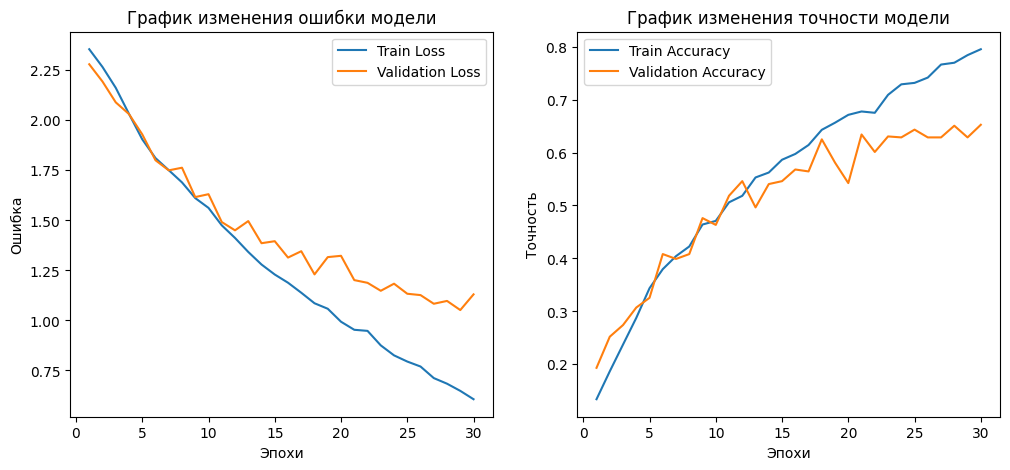

In [52]:
base_model_compilation.plot_metrics()

In [53]:
base_model_compilation.testing(test_loader=test_dataloader, checkpoint_path='./ConvNetBase_best_model.pth')

Test Accuracy: 63.42%


#### Дообучение готовой модели

In [18]:
# создание модели из resnet50
resnet50_model = create_pretrained_resnet50(num_classes=classes_count)
loss_function = nn.CrossEntropyLoss() # задаётся функция ошибки кроссэнтропия для задачи многоклассовой классификации
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.001) # оптимизатор

resnet50_model_compilation = ModelCompilation(model=resnet50_model, loss_function=loss_function, optimizer=optimizer, device=device, num_classes=classes_count)
summary(resnet50_model, input_size=(3, 224, 224))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
# Запуск обучения модели resnet50
resnet50_model = resnet50_model_compilation.fit(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=30)

Epoch 1: train_loss: 2.2287 - train_accuracy: 0.3036 - val_loss: 2.3010 - val_accuracy: 0.2114
Validation loss improved from inf to 2.3010. Saving weights... 

Epoch 2: train_loss: 2.2065 - train_accuracy: 0.3239 - val_loss: 2.3034 - val_accuracy: 0.2059
No improvement in validation loss. Best validation loss remains: 2.3010 

Epoch 3: train_loss: 2.1682 - train_accuracy: 0.3611 - val_loss: 2.2497 - val_accuracy: 0.2537
Validation loss improved from 2.3010 to 2.2497. Saving weights... 

Epoch 4: train_loss: 2.1311 - train_accuracy: 0.4019 - val_loss: 2.0845 - val_accuracy: 0.4301
Validation loss improved from 2.2497 to 2.0845. Saving weights... 

Epoch 5: train_loss: 2.1344 - train_accuracy: 0.3980 - val_loss: 2.2326 - val_accuracy: 0.2812
No improvement in validation loss. Best validation loss remains: 2.0845 

Epoch 6: train_loss: 2.1282 - train_accuracy: 0.4035 - val_loss: 2.1604 - val_accuracy: 0.3493
No improvement in validation loss. Best validation loss remains: 2.0845 

Epoch 7

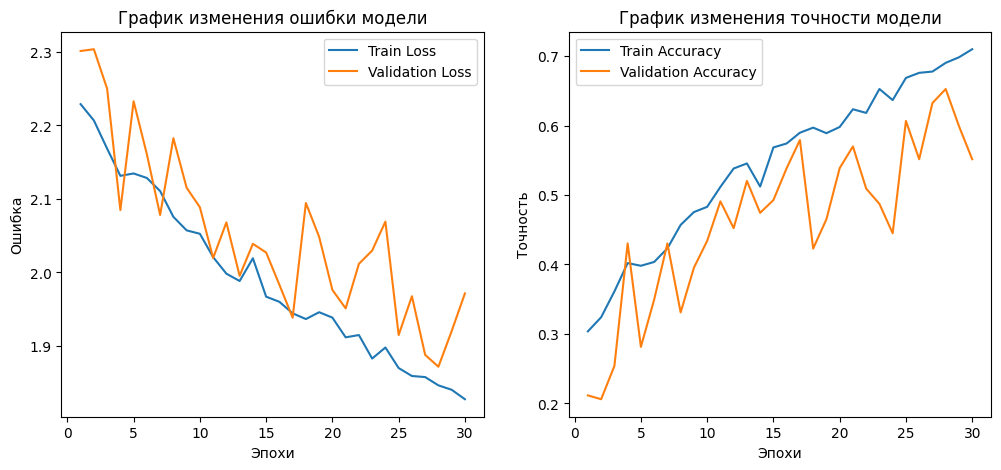

In [26]:
resnet50_model_compilation.plot_metrics()

In [27]:
resnet50_model_compilation.testing(test_loader=test_dataloader, checkpoint_path='./best_model.pth')

Test Accuracy: 63.42%


Результат сомнительный :)

#### Своя сеть

In [59]:
# создание своей модели
my_model = ConvNetRework2(num_classes=classes_count)
loss_function = nn.CrossEntropyLoss() # задаётся функция ошибки кроссэнтропия для задачи многоклассовой классификации
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001) # оптимизатор

my_model_compilation = ModelCompilation(model=my_model, loss_function=loss_function, optimizer=optimizer, device=device, num_classes=classes_count)
summary(my_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
       BatchNorm2d-2         [-1, 16, 222, 222]              32
              ReLU-3         [-1, 16, 222, 222]               0
            Conv2d-4         [-1, 32, 220, 220]           4,640
       BatchNorm2d-5         [-1, 32, 220, 220]              64
              ReLU-6         [-1, 32, 220, 220]               0
         MaxPool2d-7         [-1, 32, 110, 110]               0
            Conv2d-8         [-1, 64, 110, 110]          18,496
       BatchNorm2d-9         [-1, 64, 110, 110]             128
             ReLU-10         [-1, 64, 110, 110]               0
        MaxPool2d-11           [-1, 64, 55, 55]               0
           Conv2d-12          [-1, 128, 55, 55]          73,856
      BatchNorm2d-13          [-1, 128, 55, 55]             256
             ReLU-14          [-1, 128,

In [60]:
# Запуск обучения своей модели
my_model = my_model_compilation.fit(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=30)

Epoch 1: train_loss: 2.5586 - train_accuracy: 0.1697 - val_loss: 2.0820 - val_accuracy: 0.2978
Validation loss improved from inf to 2.0820. Saving weights... 

Epoch 2: train_loss: 2.1098 - train_accuracy: 0.2628 - val_loss: 1.9048 - val_accuracy: 0.3768
Validation loss improved from 2.0820 to 1.9048. Saving weights... 

Epoch 3: train_loss: 2.0167 - train_accuracy: 0.2993 - val_loss: 1.8314 - val_accuracy: 0.4026
Validation loss improved from 1.9048 to 1.8314. Saving weights... 

Epoch 4: train_loss: 1.9106 - train_accuracy: 0.3472 - val_loss: 1.7188 - val_accuracy: 0.4246
Validation loss improved from 1.8314 to 1.7188. Saving weights... 

Epoch 5: train_loss: 1.8186 - train_accuracy: 0.3727 - val_loss: 1.6353 - val_accuracy: 0.4412
Validation loss improved from 1.7188 to 1.6353. Saving weights... 

Epoch 6: train_loss: 1.7456 - train_accuracy: 0.3932 - val_loss: 1.6528 - val_accuracy: 0.4246
No improvement in validation loss. Best validation loss remains: 1.6353 

Epoch 7: train_loss

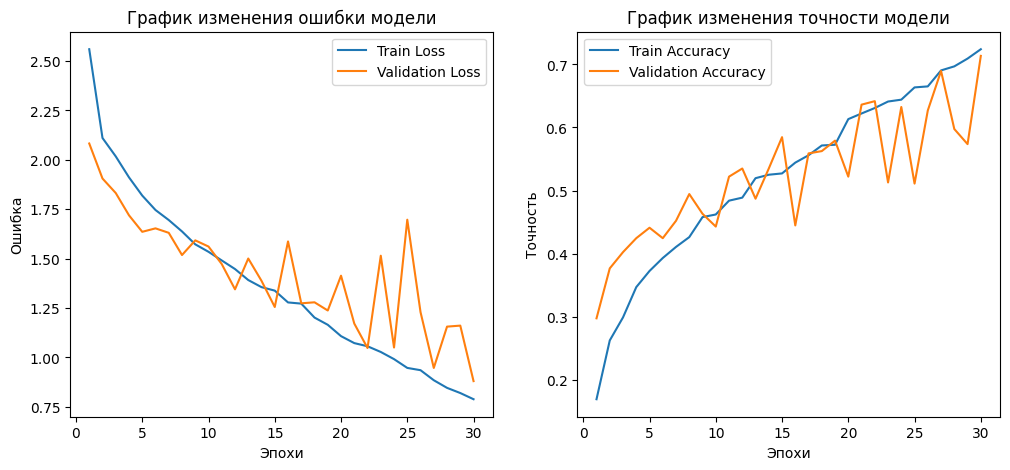

In [61]:
my_model_compilation.plot_metrics()

In [62]:
my_model_compilation.testing(test_loader=test_dataloader, checkpoint_path='./ConvNetRework2_best_model.pth')

Test Accuracy: 72.24%


## Проверяем своих котиков

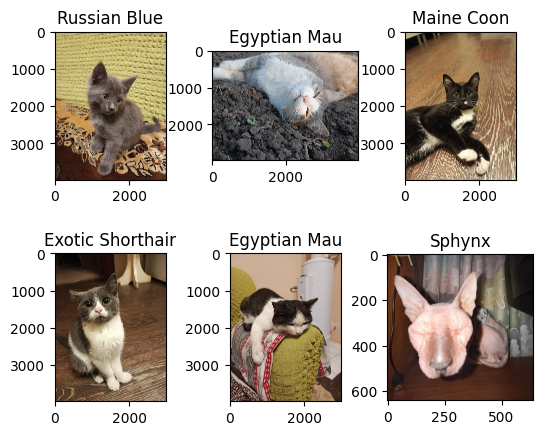

In [63]:
cat_idxs = np.arange(6)
cat_imgs = [Image.open(f'/content/drive/MyDrive/education/MLDL/lab_3_examples/cat_{idx+1}.jpg') for idx in cat_idxs]

plt.subplots_adjust(hspace=0.5)

for im_i in cat_idxs:
    plt.subplot(2, 3, im_i+1)
    plt.imshow(cat_imgs[im_i])

    my_im = transform(cat_imgs[im_i]).to(device)
    pred_class = my_model(my_im.unsqueeze(0)).squeeze().argmax()
    plt.title(categories[pred_class])

plt.show()